# Cargar los datos
Utilizar pandas

## Funciones de agrupacion

In [ ]:
def applyDeathVaccineRate(fila):
  if fila["numero_vacunados"]:
    death_ratio = fila["deaths"] / fila["numero_vacunados"]
  else:
    death_ratio = fila["deaths"]
  death_ratio = death_ratio  
  return death_ratio

def applyDeathRatio(fila):
  if(fila['confirmed']) and fila['deaths']:
    death_ratio = (fila['deaths'] / fila['confirmed']) / fila['deaths']
  else:
    if fila['deaths']:
      death_ratio = fila['deaths'] / fila['deaths'] 
    else:
      death_ratio = 0
  return death_ratio

def applyConfirmedVaccined(fila):
  if fila['confirmed']:
    result = fila['numero_vacunados'] / fila['confirmed']
  else:
    result = fila['numero_vacunados']
  
  return result

## Funciones de transformacion

In [ ]:

def formatDate(FECHA_VACUNACION):
  fecha = str(FECHA_VACUNACION)
  nueva_fecha = fecha[0:4] + '-' + fecha[4:6] + '-' + fecha[6:8]
  return nueva_fecha

def sumVacunados(Vacunacion_mod):
  vacunados = Vacunacion_mod['numero_vacunados']
  sum_vacunados = vacunados[0]
  vacunados_copy = []
  vacunados_copy.append(sum_vacunados)
  for i in range(1, len(vacunados)):
    sum_vacunados += vacunados[i]
    vacunados_copy.append(sum_vacunados)
  Vacunacion_mod['numero_vacunados'] = vacunados_copy
  return Vacunacion_mod


## Funcion principal de carga

In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


def loadCamasUci():
  Camas_uci = pd.read_csv('/content/drive/MyDrive/Topicos_IA/camas_uci.csv')
  Camas_uci = Camas_uci.rename(columns={"fecha": "date"})
  Camas_uci = Camas_uci.fillna(0)

  camas_en_uso = Camas_uci[Camas_uci['estado'].str.contains("en uso")]
  camas_en_uso = camas_en_uso.rename(columns={"total": "total_camas_en_uso"})
  camas_en_uso = camas_en_uso[{'date','total_camas_en_uso'}]

  camas_libre = Camas_uci[Camas_uci['estado'].str.contains("disponible")]
  camas_libre = camas_libre.rename(columns={"total": "total_camas_libre"})
  camas_libre = camas_libre[{'date','total_camas_libre'}]
  return camas_en_uso, camas_libre

def loadHospitalizados():
  hospitalizados = pd.read_csv('/content/drive/MyDrive/Topicos_IA/covid-19-peru-detalle-hospitalizados.csv')
  hospitalizados = hospitalizados.rename(columns={"fecha": "date"})
  hospitalizados = hospitalizados[{'date', 'hospitalizados', 'desfavorable', 'ventilacion_mecanica', 'uci'}]
  return hospitalizados


def loadData(Archivo, Vacunacion, column, region, objetivo):
  camas_en_uso, camas_libre = loadCamasUci()
  hospitalizados = loadHospitalizados()

  # agrupar para prediccion para peru
  if column == 'country':
    Archivo = Archivo[Archivo["country"].str.contains("Peru")]
    Archivo = Archivo.fillna(0)
    Archivo = Archivo[Archivo['region'] != 0]
    Archivo = Archivo.groupby('date').sum().reset_index()

    # agrupacion de la vacunacion
    Vacunacion_fecha = Vacunacion.groupby('date').count()
    Vacunacion_mod = Vacunacion_fecha.drop(columns=["DEPARTAMENTO"])
  else: # agrupar para prediccion para arequipa
    Archivo = Archivo[Archivo[column].fillna("0").str.contains(region)]
    Archivo = Archivo.fillna(0)
    
    # agrupacion de la vacunacion
    Vacunacion_departamento = Vacunacion[Vacunacion["DEPARTAMENTO"].str.contains("AREQUIPA")]
    Vacunacion_departamento = Vacunacion_departamento.groupby('date').count()
    Vacunacion_mod = Vacunacion_departamento.drop(columns=["DEPARTAMENTO"])

  Vacunacion_mod = Vacunacion_mod.rename(columns={"GRUPO_RIESGO": "numero_vacunados"})
  Vacunacion_mod = sumVacunados(Vacunacion_mod)

  # Juntar todos los datos
  Archivo = pd.merge(Archivo, Vacunacion_mod, on='date', how='left')
  Archivo = pd.merge(Archivo, camas_en_uso, on='date', how='left')
  Archivo = pd.merge(Archivo, camas_libre, on='date', how='left')
  Archivo = pd.merge(Archivo, hospitalizados, on='date', how='left')
  Archivo = Archivo.fillna(0)

  # Funciones de agrupacion
  if objetivo == 'deaths':
    Archivo['muertos_vacunas'] =  Archivo.apply(applyDeathVaccineRate, axis=1)
    Archivo['death_ratio'] = Archivo.apply(applyDeathRatio, axis=1)
    Archivo['confirmed_vaccined'] = Archivo.apply(applyConfirmedVaccined, axis=1)

  # Elijo las columnos numericas
  X = Archivo[Archivo.select_dtypes('number').columns]
  if objetivo == 'confirmed': # Elijo las columnas que me interesan para la prediccion de la confirmacion
    X = X[{'pcr_test_positive','serological_test_positive','ag_test_positive', 'pcr_serological_test_positive'}]
  else:
    # With confirmed y theta 0: Mismo patron, valores lejanos 
    #                  theta 1: Similar patron, valores cercanos 0.0001
    # With death_ratio y theta 0: Mismo patron, valores lejanos 
    #                    theta 1: Mismo patron, valores lejanos 
    # With hospitalizados y theta 0: Mismo patron, valores lejanos 
    #                       theta 1: Mismo patron, valores lejanos 
    # With confirmed_vaccined y theta 0: Mismo patron, valores lejanos 
    #                           theta 1: Mismo patron, valores lejanos 
    # With total_camas_en_uso y theta 0: Mismo patron, valores lejanos 
    #                           theta 1: Mismo patron, valores medianos 
    # With uci y theta 0: Mismo patron, valores lejanos raros  
    #            theta 1: Similar patron, valores cercanos raros  0.32
    # With muertos_vacunas y theta 0: Mismo patron, valores lejanos 
    #                      theta 1: Mismo patron, valores medianos 3.29 
    # With numero_vacunados y theta 0: Mismo patron, valores medianos 3.29 
    #                         theta 1: Similar patron, valores medianos 0.25
    
    X = X[{'confirmed','muertos_vacunas'}] #1

    # X = X[{'confirmed','muertos_vacunas', 'confirmed_vaccined'}] # 1
    # X = X[{'confirmed','muertos_vacunas', 'death_ratio'}] # 1 

  Y = Archivo[objetivo]
  # Normalizar y agregar unos para theta
  X, Y, x_means, s_stds, y_mean, y_std = normalize(X, Y)
  X = agregarUnos(X)

  return Archivo, X, Y, x_means, s_stds, y_mean, y_std

# Normalizar los datos
Normalización con el promedio y desviacion estandar

In [ ]:
def normalize(X, Y): 
  x_means = []
  x_stds = []
  for column in X:
    x_means.append(np.mean(X[column]))
    x_stds.append(np.std(X[column]))
    X[column] = (X[column] - x_means[-1]) / x_stds[-1]
                
  X = X.fillna(0)

  y_mean = np.mean(Y)
  y_std = np.std(Y)
  Y = (Y-y_mean)/y_std
  return X, Y, x_means, x_stds, y_mean, y_std

# Agregar unos para *theta*

In [ ]:
def agregarUnos(X):
  x_size = X.shape[0]
  X.insert(0, 'ones', np.ones(x_size))
  return X

# Gradiente

In [ ]:
def derivadaCosto(x_train,y_train,theta):
  m = y_train.shape[0]
  mult = np.dot(x_train, theta)
  resta = mult - y_train
  return (1/m) * np.dot(resta, x_train)

def gradiente(x_train, y_train, x_test, y_test, theta_, max_error, alpha, max_iteraciones):
  J_history = []
  iteraciones = 0
  best_theta = theta_
  
  min_error = np.inf
  error = np.inf
  while error > max_error and iteraciones < max_iteraciones:
    costo_ = derivadaCosto(x_train,y_train,theta_)
    costo_ = np.transpose(costo_)
    theta_ = theta_ - alpha * costo_
    error = mean_squared_error(y_test, prediccion(x_test, theta_))
    if error < min_error:
      best_theta = theta_
      min_error = error
    
    J_history.append(costo_)
    iteraciones += 1
  
    
  return J_history, best_theta, iteraciones

In [ ]:
def prediccion(datos, theta):
  return np.dot(datos, theta)

## Obtener rango de fechas

In [ ]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + datetime.timedelta(n)

def getDateRange(start_date,end_date):
  date_list = []
  for dt in daterange(start_date, end_date):
      date_list.append(dt.strftime("%Y-%m-%d"))
  return date_list

def selectTicks(date_list, interval):
  arr = []
  for i in range(len(date_list)):
    if i % interval == 0:
      arr.append(date_list[i])
  return arr


# Grafica

In [ ]:
from matplotlib.pyplot import figure

def plotGraphs(title, x_label, y_label, x_values, y_values, predic_mat):
  x_ticks_selected = selectTicks(x_values, 3)
  fig = plt.figure()
  plt.title(title)

  plt.scatter(x_values, y_values,label='Reales')
  plt.scatter(x_values, predic_mat,label='Prediccion')

  plt.xticks(rotation=90)
  plt.xticks(x_ticks_selected)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()


  figure(figsize=(8, 6), dpi=80)

  fig.savefig('experimento1.png')

  plt.show()

# Obtener el test y train 

In [ ]:
def trainTestSplit(Archivo, X, Y):
  # TRAIN
  mask = (Archivo['date'] < '2021-08-18')
  train = X.loc[mask]
  x_train = train[train.select_dtypes('number').columns]
  y_train = Y.loc[mask]

  # TEST
  mask = (Archivo['date'] >= '2021-08-18') & (Archivo['date'] <= '2021-10-10')
  test = X.loc[mask]
  x_test = test[test.select_dtypes('number').columns]

  y_test = Y.loc[mask]

  return x_train, x_test, y_train, y_test


# Error medio

In [ ]:
def error_medio(datos_orig, predic):
  resta_cuadrada = np.sum(np.abs(datos_orig - predic))
  return resta_cuadrada/datos_orig.shape[0]

# Ejecucion

In [ ]:
def ejecutarRegresionLinear(x_train, x_test, y_train, y_test, to_denormalize, x_label ="", y_label = "", title = ""):
  # inicializar Theta
  num_features = x_train.shape[1]
  theta = np.ones(num_features) 

  # Ejecutar la gradiente
  J_history, theta, iteraciones = gradiente(x_train, y_train, x_test, y_test,theta, 0.000001,0.0001, 10000)
  print("Theta: ", theta)

  # Calcular los errores
  predict_mat_train = prediccion(x_train, theta)
  predict_mat_test = prediccion(x_test, theta)

  error_train = mean_squared_error(y_train, predict_mat_train)
  # Desnormalizar
  # y_test=(y_test*to_denormalize[3])+to_denormalize[2]
  # predict_mat_test=(predict_mat_test*to_denormalize[3])+to_denormalize[2]
  error_test = mean_squared_error(y_test, predict_mat_test)
  print()
  print("Error in train set: ", error_train)
  print("Error in test set: ", error_test)
  
  print("erorr medio: ", end='')
  print(error_medio(y_test, predict_mat_test))
  
  # Rango de fechas para la impresion de la grafica
  start_date = datetime.date(2021, 8, 18)
  end_date = datetime.date(2021, 10, 10)

  date_list = getDateRange(start_date, end_date)
  plotGraphs(title, x_label, y_label, date_list, y_test, predict_mat_test)

  return error_train, error_test, theta, iteraciones

# Cargar Datos de vacunacion

In [ ]:
try:
  Vacunacion
except:
  columns = ["GRUPO_RIESGO", "FECHA_VACUNACION", "DEPARTAMENTO"]
  Vacunacion = pd.read_csv('/content/drive/MyDrive/Topicos_IA/vacunas_covid.csv')[columns]

  Vacunacion = Vacunacion.rename(columns={"FECHA_VACUNACION": "date"})
  Vacunacion["date"] = Vacunacion["date"].apply(formatDate)
  Vacunacion = Vacunacion.sort_values(by='date')
else:
  print("File already loaded")

File already loaded


# Experimento 1


## Prediccion de los casos positivos en arequipa

In [ ]:
execute_tests = [True, True, True, True]

In [ ]:
# Mejores valores
# theta = np.ones()
# alpha = 0.01
if execute_tests[0]:
  start_time = time.time()

  Archivo = pd.read_csv('/content/drive/MyDrive/Topicos_IA/dataset.csv')
  Vacunacion_copy = Vacunacion

  Archivo, X, Y, x_means, x_stds, y_mean, y_std = loadData(Archivo, Vacunacion_copy, 'region', 'Arequipa','confirmed')
  Archivo['date']=pd.to_datetime(Archivo['date'])
  x_train, x_test, y_train, y_test = trainTestSplit(Archivo, X, Y)

  error_train, error_test, theta, iteraciones = ejecutarRegresionLinear(x_train, x_test, y_train, y_test, [x_means, x_stds, y_mean, y_std], "Fechas", "Valores", "Prediccion de los casos confirmados en Arequipa")

  print()
  print("Iteraciones: " + str(iteraciones))
  print("--- %s minutes ---" % ((time.time() - start_time)/60))

## Prediccion de las muertes en arequipa

Theta:  [0.95241845 0.94507039 1.00425618]

Error in train set:  2.5373050710349827
Error in test set:  0.00043122439647425324
erorr medio: 0.018945864362151493


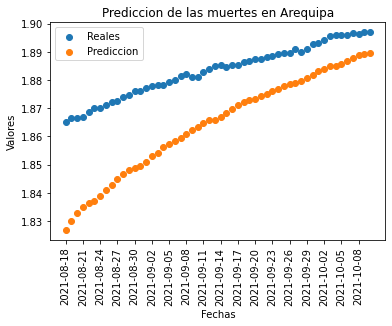

<Figure size 640x480 with 0 Axes>


Iteraciones: 10000
--- 0.42554910977681476 minutes ---


In [ ]:
# Mejores valores
# theta = np.ones()
# alpha = 0.0001
if execute_tests[1]:
  start_time = time.time()

  Archivo = pd.read_csv('/content/drive/MyDrive/Topicos_IA/dataset.csv')
  Vacunacion_copy = Vacunacion

  Archivo, X, Y, x_means, x_stds, y_mean, y_std = loadData(Archivo, Vacunacion_copy, 'region', 'Arequipa','deaths')
  Archivo['date']=pd.to_datetime(Archivo['date'])

  x_train, x_test, y_train, y_test = trainTestSplit(Archivo, X, Y)
  error_train, error_test, theta, iteraciones = ejecutarRegresionLinear(x_train, x_test, y_train, y_test, [x_means, x_stds, y_mean, y_std], "Fechas", "Valores", "Prediccion de las muertes en Arequipa")
  print()
  print("Iteraciones: " + str(iteraciones))
  print("--- %s minutes ---" % ((time.time() - start_time)/60))

# Experimento 2

## Prediccion de los casos positivos en el peru

In [ ]:
# Mejores valores
# theta = np.ones()
# alpha = 0.01
if execute_tests[2]:
  start_time = time.time()

  Archivo = pd.read_csv('/content/drive/MyDrive/Topicos_IA/dataset.csv')
  Vacunacion_copy = Vacunacion

  Archivo, X, Y, x_means, x_stds, y_mean, y_std = loadData(Archivo, Vacunacion_copy,'country', 'Peru','confirmed')
  Archivo['date']=pd.to_datetime(Archivo['date'])

  x_train, x_test, y_train, y_test = trainTestSplit(Archivo, X, Y)

  error_train, error_test, theta, iteraciones = ejecutarRegresionLinear(x_train, x_test, y_train, y_test, [x_means, x_stds, y_mean, y_std], "Fechas", "Valores", "Prediccion de los casos confirmados en Peru")

  print("Iteraciones: " + str(iteraciones))
  print("--- %s minutes ---" % ((time.time() - start_time)/60))

## Prediccion de las muertes en el peru

In [ ]:
# Mejores valores
# theta = np.ones()
# alpha = 0.001
if execute_tests[3]:
  start_time = time.time()

  Archivo = pd.read_csv('/content/drive/MyDrive/Topicos_IA/dataset.csv')
  Vacunacion_copy = Vacunacion

  Archivo, X, Y, x_means, x_stds, y_mean, y_std = loadData(Archivo, Vacunacion_copy,'country', 'Peru','deaths')
  Archivo['date']=pd.to_datetime(Archivo['date'])
  x_train, x_test, y_train, y_test = trainTestSplit(Archivo, X, Y)

  error_train, error_test, theta, iteraciones = ejecutarRegresionLinear(x_train, x_test, y_train, y_test, [x_means, x_stds, y_mean, y_std], "Fechas", "Valores", "Prediccion de las muertes en Peru")

  print()
  print("Iteraciones: " + str(iteraciones))
  print("--- %s minutes ---" % ((time.time() - start_time)/60))